In [1]:
from sparkling import Run
from sparkling.parameters.initializations import INITIALIZATION_2D
from sparkling.utils.shots import convert_NCxNSxD_to_NCNSxD
#from sparkling.utils.plotting import scatter_shots
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity
from modopt.math.metrics import ssim

from mri.operators import NonCartesianFFT, WaveletN
from mri.operators.utils import normalize_frequency_locations


import numpy as np
import copy
#import os
import matplotlib.pyplot as plt

from skimage import io
import nibabel as nib

/home/guillaume/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.4     installed
scikit-learn   : >=0.19.1  - requi

# Sparkling

In [2]:
def get_sparkling(INITIALIZATION, verbose=0):
    runObj = Run(**INITIALIZATION, verbose=verbose)
    runObj.initialize_shots()
    while runObj.current['decim'] >= 1:
        runObj.start_optimization()
        runObj.update_params_decim(do_decimation=True)
    shots = convert_NCxNSxD_to_NCNSxD(runObj.current['shots'])
    return normalize_frequency_locations(shots)

In [3]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

In [4]:
opt_density = np.genfromtxt("saved_densities/T2w_medpen_150.csv", delimiter=',')
n_dim = int(np.sqrt(len(opt_density)))
density = opt_density[:-1].reshape((n_dim,n_dim))
density /= np.sum(density)

im = nib.load("oasis_data/T2w/sub-OAS30001_sess-d0129_acq-TSE_T2w.nii")
im = im.get_fdata()

cartesian_image = (1+0j)*im[:,:,10]
cartesian_image = reduce_img_size(n_dim,cartesian_image)
print( cartesian_image.shape )
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=3,
    padding_mode = 'periodization'
)

(150, 150)


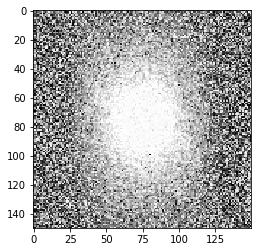

In [5]:
plt.figure()
plt.imshow(density,cmap='gray')
#plt.savefig("Results/Upper Level/Penalty_strength_V2/Initial_mask.png")
plt.show()

In [6]:
# Save the parameters
mus = np.logspace(-5, -10, 10)
metrics = {
    'ssim': {
        'metric': ssim,
        'mapping': {'x_new': 'test', 'y_new': None},
        'cst_kwargs': {'ref': cartesian_image, 'mask': None},
        'early_stopping': True,
    },
}

#decay = 10
#cutoff = 10 
init = copy.deepcopy(INITIALIZATION_2D)
init['dist_params']['mask'] = False
init['traj_params']['num_shots'] = int(n_dim/2)
init['traj_params']['num_samples_per_shot'] = int(n_dim*np.pi)
init['traj_params']['initialization'] = 'RadialIO'
init['recon_params']['img_size'] = n_dim
#init['dist_params']['cutoff'] = cutoff
#init['dist_params']['decay'] = decay
init['algo_params']['max_grad_iter'] = 100
init['algo_params']['max_proj_iter'] = 100
init['algo_params']['start_decim' ] = 16

/home/guillaume/CSMRI_sparkling-master/sparkling/parameters/algorithm.py:45: UserWarning: Cupy is not installed, please install it to use GPU! Proceeding with CPU projection for now on1cores
  "now on" + str(proj_n_cpu) + "cores")


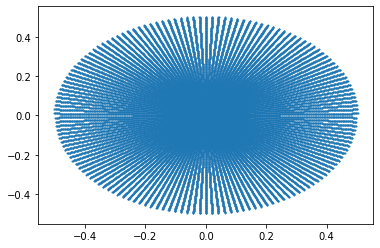

/home/guillaume/CSMRI_sparkling-master/sparkling/parameters/algorithm.py:45: UserWarning: Cupy is not installed, please install it to use GPU! Proceeding with CPU projection for now on1cores
  "now on" + str(proj_n_cpu) + "cores")
/home/guillaume/anaconda3/lib/python3.7/site-packages/modopt/opt/algorithms.py:114: UserWarning: CuPy is not installed, cannot run on GPU! Running optimization on CPU
  warnings.warn("CuPy is not installed, cannot run on GPU! "


Algorithm Parameters
--------------------------------------------------
Use GPU for Projection? : = False 
FMM Parameters :  = {'fmm_method': 'gpu_direct_pykeops'} 
Remove the TE points from the equation = True 
Tolerance for algorithm convergence check = 0 
Projection at every :  = 1 Iterations
Should we do shaking of points = False 
Initial Step Size = 0.009947183943243459 
Number of Cores for Projection step = 1 
Decimation at start = 16 
Maximum Iterations for Gradient Step = 100 
Maximum Iterations for Projection Step = 100 

Initializing Trajectory Parameters
--------------------------------------------------
0.1
10
Oversampling Factor (Gradient Raster Time/Gradient Dwell Time) = 1 
Number of Samples per Shot = 471.0 samples/shot
Number of stacks for SOS = None 
Type of Initialization = RadialIO init
Number of Shots = 75 shots
Dimension = 2 D
None

Reconstruction Parameters
--------------------------------------------------
Field of View = [0.23 0.23] m
Resolution of Reconstructe

100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
/home/guillaume/anaconda3/lib/python3.7/site-packages/modopt/opt/algorithms.py:114: UserWarning: CuPy is not installed, cannot run on GPU! Running optimization on CPU
  warnings.warn("CuPy is not installed, cannot run on GPU! "


Updating Kinect Constraints : 
------------------------------
Speed Bound = [0.01697653 0.01697653]
Acceleration Bound = [0.02393889 0.02393889]
------------------------------
+++ Starting Optimization +++
Number of Gradient iterations = 100
Number of Projection Steps = 100
Number of Cores for Projection = 1
Using GPU for Projection?  False
Decimation 8.0


100% (100 of 100) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/guillaume/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-03b3a97af10c>", line 11, in <module>
    kspace_loc = get_sparkling( init, verbose = 10 )
  File "<ipython-input-2-2aafc4c140e7>", line 5, in get_sparkling
    runObj.start_optimization()
  File "/home/guillaume/CSMRI_sparkling-master/sparkling/parameters/setup_params.py", line 138, in start_optimization
    **self.algo_params.fmm_params()
  File "/home/guillaume/CSMRI_sparkling-master/sparkling/optimization/projected_gradient_descent.py", line 65, in __init__
    self.iterate(max_iter=num_iterations)
  File "/home/guillaume/CSMRI_sparkling-master/sparkling/optimization/projected_gradient_descent.py", line 105, in iterate
    self._run_alg(max_iter)
  File "/home/guillaume/anaconda3/lib/python3.7/site-packages/modopt/opt/algorithms.py", line 279, in _run_a

KeyboardInterrupt: 

In [7]:
inObj = Run( **init, verbose = 0 )
inObj.initialize_shots()
in_kspace_loc = np.pi * convert_NCxNSxD_to_NCNSxD( inObj.traj_params.init_shots )

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.scatter( in_kspace_loc[ :, 0 ], in_kspace_loc[ :, 1 ], s = 1 )
plt.show()
init['dist_params']['density'] = density

kspace_loc = get_sparkling( init, verbose = 10 )
fourier_op = NonCartesianFFT(samples=kspace_loc, \
                                 shape=cartesian_image.shape, implementation='cpu')
kspace_obs = fourier_op.op(cartesian_image)

# Reconstruction

In [36]:
import pysap
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import f1,f2,g

fourier_op = NonCartesianFFT(samples=kspace_loc, shape=cartesian_image.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(cartesian_image)+0.15*np.mean(cartesian_image)*np.random.randn(2*len(kspace_loc)).view(np.complex128)
param = {"epsilon":1e-3,"gamma":1e-10}

p = np.ones(len(y)+1)
p[-1] = opt_density[-1]

uk,norms,energy,ssims = pdhg(y , p ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             const = {"sigma":0.5,"tau":1},
                             ground_truth=cartesian_image,
                             maxit=100,
                             compute_energy = True,
                             mask_type="non-cartesian")

Sigma: 0.5 
Tau: 1
10  iterations:
Cost: 416395251289.5167 
Norm: 1.571953893304737 

20  iterations:
Cost: 318028959.1645325 
Norm: 0.353693249244303 

30  iterations:
Cost: 161523151.34863797 
Norm: 0.01798005000328512 

40  iterations:
Cost: 160450223.3773774 
Norm: 0.009235812526516604 

50  iterations:
Cost: 159819697.55569953 
Norm: 0.008601893977921448 

60  iterations:
Cost: 159385699.1856241 
Norm: 0.006782784077650679 

70  iterations:
Cost: 159095964.50526425 
Norm: 0.005752229857286215 

80  iterations:
Cost: 158896756.40283534 
Norm: 0.004544555441797576 

90  iterations:
Cost: 158765492.24560213 
Norm: 0.004235087528711648 

100  iterations:
Cost: 158685439.77193004 
Norm: 0.0035960016848120635 

Finished in 133.0990765094757 seconds.


In [27]:
print(ssim(uk,cartesian_image))
print(len(kspace_loc))
pysap.Image(data = np.abs(uk)).show()

0.8679174102596607
35325


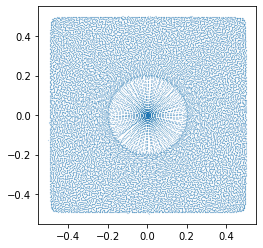

In [28]:
fig = plt.figure( )
ax1 = fig.add_subplot( 1, 1, 1 )
ax1.scatter( kspace_loc[ :, 0 ], kspace_loc[ :, 1 ], s = 0.01 )
ax1.set_aspect( 'equal' )
#plt.savefig("saved_densities/sparkling_trajectories/sparkling_uniform_150.png")
plt.show()

## Cartesian scheme

In [29]:
x = np.linspace(0,n_dim,n_dim,endpoint=False)/n_dim-0.5
y = np.linspace(0,n_dim,n_dim,endpoint=False)/n_dim-0.5
X,Y = np.meshgrid(x,y)
cartesian_kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

fourier_op = NonCartesianFFT(samples=cartesian_kspace_loc, shape=cartesian_image.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(cartesian_image)+0.15*np.mean(cartesian_image)*np.random.randn(2*n_dim**2).view(np.complex128)
param = {"epsilon":1e-3,"gamma":1e-10}

p = np.ones(len(y)+1)
p[-1] = opt_density[-1]

uk,norms,energy,ssims = pdhg(y , p ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             const = {"sigma":0.1,"tau":5},
                             ground_truth=cartesian_image,
                             maxit=60,
                             compute_energy = True,
                             mask_type="")

Sigma: 0.1 
Tau: 5
10  iterations:
Cost: 253600878.5933461 
Norm: 0.5220152826464557 

20  iterations:
Cost: 119544948.3711799 
Norm: 0.021853170487067527 

30  iterations:
Cost: 119357908.92701009 
Norm: 0.006440591293855123 

40  iterations:
Cost: 119325776.75725426 
Norm: 0.0028692085292410796 

50  iterations:
Cost: 119310913.21568409 
Norm: 0.0014585120195166475 

60  iterations:
Cost: 119302829.72278732 
Norm: 0.0008112852954134009 

Finished in 3.0704047679901123 seconds.


In [30]:
print(ssim(uk,cartesian_image))
pysap.Image(data = np.abs(uk)).show()

0.8934216454215606
